# Physical Sources

In [15]:
#------ manually fix import
import sys
import pathlib
import os

parent_folder = pathlib.Path(os.path.abspath('')).parents[0]
sys.path.append(str(parent_folder)+'\\ObservationSimulator')
sys.path.append('D:/PhD/ownCloud/end-to-end-simulation/ObservationSimulator/')
#------

import hcipy as hp
import numpy as np
import matplotlib.pyplot as plt
import ObservationSimulator as obs

import astropy.units as u
import astropy.coordinates as c
from astropy.time import Time

In this file we will create a basic simulation of a target with a physical location, along with a telescope with a physical location. The rest of the simulation is done as described in the 'Setting up a basic simulation' example. We will observe three point sources near the location of M33 with a telescope in Leiden. The backend of the systems used here is based on the `astropy.coordinates` module, whose documentation can be found at https://docs.astropy.org/en/stable/coordinates/index.html. Objects from this package are also required as input for the physical location parameters of `Source`s and `Telescope`. We start with defining our simulation parameters. Note that we also require an observing time in addition to the location of every object.

In [16]:
# parameters
lam = 1*u.um
F = 10
D = 1*u.m
R = 300
observing_time = Time('2021-6-29 03:30:00')
source_name = 'M33'
wavelengths = obs.make_wavelengths(R, 'R')
observatory_location = [52.154902*u.deg, 4.483179*u.deg, 20*u.m] # old observatory Leiden

Next we create the `astropy.coordinates` objects to set the physical locations of the sources and telescope. The observatory location must be an `EarthLocation` (see https://docs.astropy.org/en/stable/api/astropy.coordinates.EarthLocation.html), while sources require a `SkyCoord` or derived class (see https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html).

In [17]:
telescope_location = c.EarthLocation(lat=observatory_location[0], lon=observatory_location[1], height=observatory_location[2])
loc1 = c.SkyCoord.from_name(source_name)
loc2 = c.SkyCoord(ra = loc1.ra + 0*u.arcsec, dec = loc1.dec + 3*u.arcsec)
loc3 = c.SkyCoord(ra = loc1.ra + 3*u.arcsec, dec = loc1.dec + 0*u.arcsec)

utc_offset = 2*u.hour # correction for UTC
exp_time = observing_time - utc_offset

Either the `location` or `physical_location` attribute of a `Source` can be set with a `SkyCoord` (though the latter always need a `SkyCoord`, unlike the former). If you set `location` in this case, in the background the `physical_location` of the source will be set.

In [18]:
# make sources
source1 = obs.Source(wavelengths, location = loc1) # can either set location or physical_location with a SkyCoord
source2 = obs.Source(wavelengths, physical_location = loc2)
source3 = obs.Source(wavelengths, location = loc3)

The `Telescope` now needs its attributes `location` and `observation_time` set in order to be able to run the simulation, as there is no way to convert the physical location of the sources to a relative offset for the telescope without knowning these. In addition, the pointing of the telescope is now essential, and can be controlled through the `point_at` method, which points the telescope at a specific source. For simulations with multiple time steps it is recommended to use the `track` method, which updates the telescope pointing at every timestep.

In [19]:
# make optical system
t = obs.Telescope(diameter = D, q=4, field_of_view = 3*u.arcsec, f_number = F, reference_wavelength=lam, location=telescope_location, observation_time = exp_time)
t.point_at(source1)

The rest of the simulation makes no reference to the physical location of any object.

Total runtime: 0.893 s.
Time spent on overhead: 0.00401 s.
----------
Time spent per component:
	<ObservationSimulator.simulation.components_hcipy.hcipyPupilGenerator object at 0x050E0F58>:	0.321 s
	<ObservationSimulator.simulation.base.ComponentSequence object at 0x050E0A18>:	0.509 s
	<ObservationSimulator.simulation.detector.Detector object at 0x1BC07418>:	0.0593 s


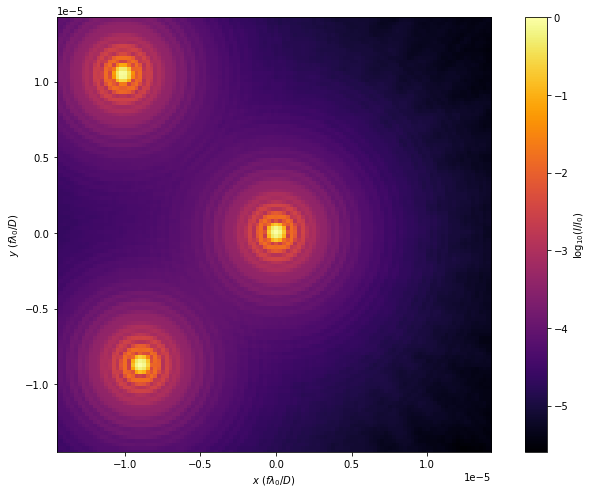

In [20]:
x0 = obs.hcipyPupilGenerator(t)
x = obs.ComponentSequence([t.aperture(), t.propagator()])(x0)
x = obs.Detector()(x)

sim = obs.Simulation(first_component = x0)
sim.run([source1, source2, source3])
sim.statistics()

image = x.read_out()

plt.figure(figsize=(12,8))
im = hp.imshow_field(np.log10(image/image.max()), cmap='inferno', grid_units = (F*lam/D).value)
plt.colorbar(im, label = r"log$_{10}(I/I_0)$")
plt.xlabel(r"$x$ ($f\lambda_0/D$)")
plt.ylabel(r"$y$ ($f\lambda_0/D$)")

plt.show()